# Análise de Sentimento - Críticas de Filmes

## Objetivo:
- Desejou-se chegar em um modelo preditor satisfatório para prever se determinada crítica de filme seria positiva ou negativa.
Tal modelo, foi baseado em técnicas de NLP e Machine Learning em que o dataset, com críticas previamente classificadas como positivas ou negativas, está disponível em: https://www.kaggle.com/datasets/luisfredgs/imdb-ptbr.

- ###### Machine Learning:
 - Modelo de classificação utilizando regressão logística
 - Verificação de acurácia do modelo utlizando validação cruzada

- ###### NLP:
 - Preprocessamento de textos
 - Comparação entre técnica de Bag of Words e TFIDF (term frequency–inverse document frequency) e acurácia dos modelos gerados

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('rslp')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
from nltk import tokenize
from string import punctuation
from unidecode import unidecode
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\regis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\regis\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [2]:
def pareto(dados, coluna_texto, quantidade):
    textos = []
    textos.append(dados.query("sentiment == 1"))
    textos.append(dados.query("sentiment == 0"))
    figs, axs = plt.subplots(2, 1, figsize=(12,8))
    for texto, ax, title in zip(textos, axs, ["Positivo", "Negativo"]):
        todas_palavras = ' '.join([resenha for resenha in texto[coluna_texto]])
        token_espaco = nltk.tokenize.WhitespaceTokenizer()
        token_frase = token_espaco.tokenize(todas_palavras)
        frequencias = nltk.FreqDist(token_frase)
        df_frequencias = pd.DataFrame({'Palavras': list(frequencias.keys()),
                                      'Frequencia': list(frequencias.values())})
        df_frequencias = df_frequencias.nlargest(n=quantidade, columns='Frequencia')
        total = df_frequencias['Frequencia'].sum()
        df_frequencias['Porcentagem'] = df_frequencias['Frequencia'].cumsum() / total * 100
        ax = sns.barplot(data=df_frequencias, x='Palavras', y='Frequencia', color='gray', ax=ax)
        ax2 = ax.twinx()
        sns.lineplot(data=df_frequencias, x='Palavras', y='Porcentagem', color='red', marker='D', sort=False, ax=ax2)
        ax.set_title(title)
        ax2.set_ylim([0,110])
    plt.show()

In [3]:
def word_cloud(dados):
    
    fig, ax = plt.subplots(2,1, figsize=(20,14))
    
    for sentiment in ['0', '1']:
        dados_ = dados.query('sentiment == ' + sentiment)
        all_text = " ".join([text for text in dados_.processed_text_pt])
        word_cloud = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(all_text)
        
        if sentiment == '0':
            title = 'Negativa'
        else:
            title = 'Positiva'
        
        plt.sca(ax[int(sentiment)])
        plt.imshow(word_cloud, interpolation='bilinear')
        plt.title(title)
        plt.axis('off')
    plt.show()

- ### Importação e Tratamento dos dados

In [4]:
# importando dados a serem analisados

dados = pd.read_csv("dados/imdb-reviews-pt-br.csv")
dados.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


In [5]:
# trocando classes por números

troca = {
    'neg': 0,
    'pos': 1
}

dados.sentiment = dados.sentiment.map(troca)
dados.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",0
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,0
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",0
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,0
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,0


In [6]:
# fazendo melhorias nos textos para melhorar a análise

# transformando em minúsculo e retirando acentos
dados['processed_text_pt'] = [unidecode(text.lower()) for text in dados.text_pt]

# retirando stop words e pontuacao
token_pontuacao = tokenize.WordPunctTokenizer()
pontuacao = [i for i in punctuation]

stop_words = nltk.corpus.stopwords.words("portuguese")
stop_words += pontuacao

# --retirando acentos das stop_words
stop_words = [unidecode(word) for word in stop_words]

clear_texts = []
for text in dados.processed_text_pt:
    text_clear = [word for word in token_pontuacao.tokenize(text) if word not in stop_words]
    clear_texts += [" ".join(text_clear)]
dados["processed_text_pt"] = clear_texts

In [7]:
# Retirando o sufixo das palavras - reduzindo ao radical comum

stemmer = nltk.RSLPStemmer()
token_space = nltk.tokenize.WhitespaceTokenizer()

clear_texts = []
for text in dados.processed_text_pt:
    text_clear = [stemmer.stem(word) for word in token_space.tokenize(text)]
    clear_texts += [" ".join(text_clear)]
dados['processed_text_pt'] = clear_texts

- ### Visualização dos dados tratados

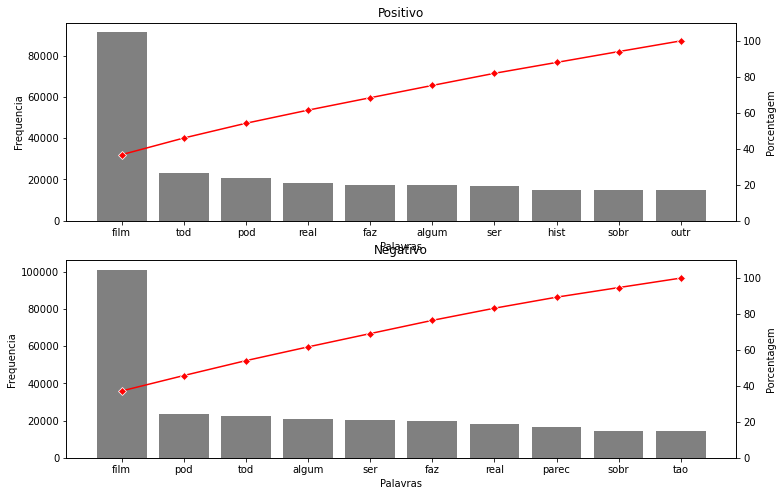

In [8]:
pareto(dados, "processed_text_pt", 10)

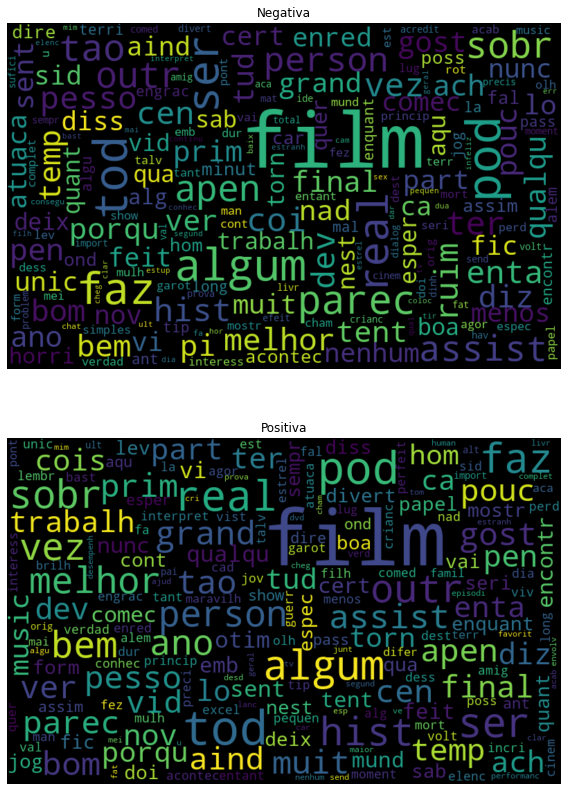

In [9]:
word_cloud(dados)

- ### Geração e verificação dos modelos

In [10]:
# Modelo - Classificação (Regressão Logística) usando Bag of Words:

# Criando Bag of Words

vectorize = CountVectorizer(max_features=50)
bag_of_words = vectorize.fit_transform(dados['processed_text_pt'])

x = bag_of_words
y = dados.sentiment

np.random.seed(20)
train_x, test_x, train_y, test_y = train_test_split(x, y)

# Modelo de Regressão Logística
reg_log = LogisticRegression()
reg_log.fit(train_x, train_y)

cv = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_validate(reg_log, x, y, cv=cv, return_train_score=False)

media = results['test_score'].mean()
desv_pad = results['test_score'].std()
print("Bag of Words:")
print("Accuracy, média: %.2f %%" % (media * 100))
print("Accuracy com cross validation, intervalo: [%.2f, %.2f%%]" % ((media - 2 * desv_pad) * 100, (media + 2 * desv_pad) * 100))

Bag of Words:
Accuracy, média: 69.39 %
Accuracy com cross validation, intervalo: [68.15, 70.64%]


In [11]:
# Modelo - Classificação (Regressão Logística) usando Tfidf:

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit(dados.processed_text_pt)
tfidf_dados = tfidf.transform(dados.processed_text_pt)

x = tfidf_dados
y = dados.sentiment

np.random.seed(20)
train_x, test_x, train_y, test_y = train_test_split(x, y)

# Modelo de Regressão Logística
reg_log = LogisticRegression()
reg_log.fit(train_x, train_y)

cv = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_validate(reg_log, x, y, cv=cv, return_train_score=False)

media = results['test_score'].mean()
desv_pad = results['test_score'].std()
print("Tfidf:")
print("Accuracy, média: %.2f %%" % (media * 100))
print("Accuracy com cross validation, intervalo: [%.2f, %.2f%%]" % ((media - 2 * desv_pad) * 100, (media + 2 * desv_pad) * 100))

C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\regis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Tfidf:
Accuracy, média: 88.74 %
Accuracy com cross validation, intervalo: [88.00, 89.49%]


- ##### Observou-se que o melhor modelo foi gerado utilizando TFIDF

- ### Análise dos resultados obtidos para o melhor modelo

In [12]:
pesos = pd.DataFrame(reg_log.coef_[0].T, index=tfidf.get_feature_names())
print("Top 10 - Palavras que remetem a 'positivo':")
pesos.nlargest(10,0)

Top 10 - Palavras que remetem a 'positivo':


,0
excel,8.311538
otim,7.856752
perfeit,6.386525
maravilh,5.804552
favorit,5.802160
incri,4.937580
divert,4.707843
ador,4.543587
agrada,4.246154
hilari,4.238334


In [13]:
print("Top 10 - Palavras que remetem a 'negativo':")
pesos.nsmallest(10,0)

Top 10 - Palavras que remetem a 'negativo':


,0
pi,-9.434974
ruim,-9.136576
horri,-8.556930
chat,-7.543550
terri,-7.521285
nad,-5.925831
decepca,-5.135323
nenhum,-5.106899
infeliz,-4.965608
lix,-4.949721


- ##### Observa-se que está bem coerente os resultados de palavras que remetem a críticas positivas e negativas, já que palavras como "Excelente", "Perfeito" estão relacionadas a posistivas e "Ruim", "Horrível" a negativas. O que se mostra bem coerente.

- ### Testando o modelo

In [14]:
def tratar_texto(texto):
    stemmer = nltk.RSLPStemmer()
    token_pontuacao = tokenize.WordPunctTokenizer()
    pontuacao = [i for i in punctuation]
    stop_words = nltk.corpus.stopwords.words("portuguese")
    texto_tratado = unidecode(texto.lower())
    stop_words += pontuacao
    stop_words = [unidecode(word) for word in stop_words]
    texto_tratado = [stemmer.stem(word) for word in token_pontuacao.tokenize(texto_tratado) if word not in stop_words]
    texto_tratado = " ".join(texto_tratado)
    return texto_tratado

In [24]:
# Testando modelo em um texto

texto_1 = '''
É um ótimo filme! e para min o diretor foi ousado ao fazer um Batman totalmente diferente de todos feitos até hoje,
sendo suspense polícial do começo ao fim, o Batman é detetive.... e neste filme ele exerce seu poder de detetive.
Lembrando que ele ainda está no segundo ano como Batman e tem muita coisa para aprender ainda nos próximos filmes que com
certeza vai ter continuação. O ator Robert Pattinson ficou excelente no papel de Batman, fora todos os outros atores que
foram muito bem escolhidos e ficaram bens em seus papéis. Pra min neste filme tem uma cena de perseguição que é a melhor
de todos os Batman. Em fim é um ótimo filme que te prende do começo ao fim. Tom sombrio e trilha sonora impecável que para
min o Batman tem que ser desse jeito mesmo, sem risadas e, quem crítica o filme do Batman pelo o fato de ser um filme muito
sombrio e sério de fato não manja nada de Batman... Se querem ver humor vão para o filme da Marvel.
'''

texto_2 = '''
Não gostei! Decepção! O longa está com uma vibe muito gótica, horrível, lembrando em momento o filme "O Corvo".
Pattinson não convence no personagem, demonstrando fraqueza e medo nas cenas, que não combinam com o herói e o conjunto não agrada.
Dificilmente será superado pelos antecessores. Até a caracterização é ruim. O ponto alto vai pra trilha sonora, bem escolhida.
'''

In [25]:
texto_1_tratado = tratar_texto(texto_1)
texto_2_tratado = tratar_texto(texto_2)

In [35]:
x = tfidf.transform([texto_1_tratado, texto_2_tratado])
y_hat = reg_log.predict(x)

df_resp = pd.DataFrame({'Texto': ['texto_1', 'texto_2'], 'Sentimento Previsto': y_hat})

In [36]:
troca = {
    1: 'Positivo',
    0: 'Negativo'
}

df_resp['Sentimento Previsto'] = df_resp['Sentimento Previsto'].map(troca)
df_resp

,Texto,Sentimento Previsto
0,texto_1,Positivo
1,texto_2,Negativo
